## ConfidNet Implementation on MNIST Dataset

In this notebook we are going to implement the Confidence Network based on the paper : Addressing Failure Prediction
by Learning Model Confidence.

So, lets get our hands dirty by importing the necessary packages.

In [1]:
## Importing necessary packages ##

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import PIL

Now moving on, we will fetch our dataset. But we are going to bring in after applying some transformation.

In [2]:
## Defining the transformation ##

aug = transforms.Compose([
    transforms.Resize((28 , 28)),
    transforms.ToTensor()
])

We make only resize transform. It is kind of unnecessary (Since they are already 28 * 28) but we do it just for the sake of it.

In [27]:
## Downloading the dataset ##

mnist_data = ImageFolder(root = 'trainingSet' , 
                         transform = aug)

print('----Data Loaded Successfully----')
print('----Number of Images =' , len(mnist_data) , '----')
print('----Image dimension =' , mnist_data[45][0].shape , '----')

----Data Loaded Successfully----
----Number of Images = 42000 ----
----Image dimension = torch.Size([3, 28, 28]) ----


Now like we always do, lets visualize a sample data.

Label : 1


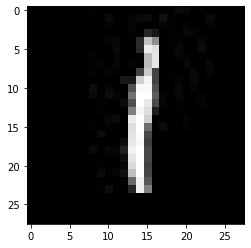

In [4]:
## Visualizing a sample data ##

rand_idx = int(np.random.randint(low = 0 , high = len(mnist_data) , size = 1))

img , label = mnist_data[rand_idx]


print('Label :' , label)
plt.imshow(img.permute(1 , 2, 0))
plt.show()

Now we need to set our dataloader.

In [5]:
## Setting our dataloader ##

mnist_dataloader = DataLoader(dataset = mnist_data,
                      batch_size = 32 , 
                      shuffle = True)

print('----Data Loader Implemented Successfully----')
print('----Number of Batches =' , len(mnist_dataloader) , '----')

----Data Loader Implemented Successfully----
----Number of Batches = 1313 ----


Now lets visualize a batch of data.

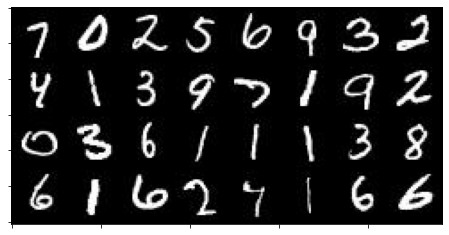

In [6]:
## Visualizing a batch of data ##

for img , _ in mnist_dataloader:
    fig , ax = plt.subplots(figsize = (8 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(img).permute(1 , 2 , 0))
    
    break

In [7]:
## Transfering the data into GPU ##

def get_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

## Setting the device ##

device = get_device()


def transfer_data(data , device):
    
    if isinstance(data , (list , tuple)):
        return [transfer_data(each_data , device) for each_data in data]
    
    return data.to(device)

## GPU DataLoader ##

class GpuDL:
    
    def __init__(self , data , device):
        
        self.data = data
        self.device = device
        
    def __iter__(self):
        
        for each_data in self.data:
            
            yield transfer_data(each_data , self.device)
    
    def __len__(self):
        
        return len(self.data)

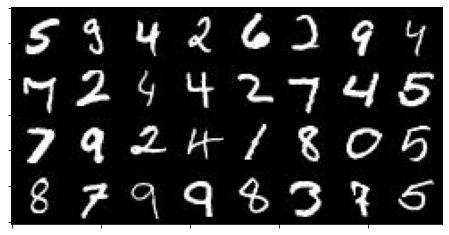

In [8]:
## Setting our GPU Datalader ##

mnist_dl = GpuDL(mnist_dataloader , device)

## Visualizing ##

for img , _ in mnist_dl:
    fig , ax = plt.subplots(figsize = (8 , 4))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(img.to('cpu')).permute(1 , 2 , 0))
    
    break

Now with the dataset out of way.

Let's make our masterpiece-- our ConfidNet model.

Well, the ConfidNet model is not that special. It is just like any other model, but it shifts itself by having two outpoints.

To make ConfidNet what we need to do is make a CNN extractor. A smaller model will also work.

This extracted feature map then diverges into two parts:
1. Goes out to make a classification as a normal classifier.
2. The second one predicts a confidence value via a simple MLP.

So lets go!

In [9]:
## Making our model ##

## Making Extractor ##

class CNN_Extractor(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 64 , kernel_size = 3 , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2), ## 14 * 14 ##
            nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 3 , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2), ## 7 * 7 ##
            nn.Conv2d(in_channels = 128 , out_channels = 256 , kernel_size = 3 , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2), ## 3 * 3 ##
            nn.Conv2d(in_channels = 256 , out_channels = 512 , kernel_size = 3 , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2), ## 1 * 1 ##
            nn.Flatten()
        )
        
    def forward(self , x):
        
        out = self.extractor(x)
        
        return out
    

## Making the classifier ##

class Main_Classier(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 512 , out_features = 10)
        )
        
    def forward(self , x):
        
        out = self.classifier(x)
        
        return out
    
## Making the Confidence model ##

class ConfidNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.confid = nn.Sequential(
            nn.Linear(in_features = 512 , out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256 , out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128 , out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64 , out_features = 32),
            nn.ReLU(),
            nn.Linear(in_features = 32 , out_features = 1)
        )
        
    def forward(self , x):
        
        out = self.confid(x)
        
        return out

Now we will do something different here. We are going to make the classifier model separately, since it needs to stay fixed.

In [10]:
## End to End Classifier ##

class MNIST_Classifier(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.feature_extractor = CNN_Extractor()
        
        self.classifier = Main_Classier()
        
    def forward(self , x):
        
        features = self.feature_extractor(x)
        
        out = self.classifier(features)
        
        return features , out

Now lets set the model objects.

In [11]:
## Setting the model objects ##

class_model = MNIST_Classifier().to(device)

conf_model = ConfidNet().to(device)

With that done and dusted, lets set our loss functions.

In [12]:
## Classifier loss ##

class_loss = nn.CrossEntropyLoss()

## Confidence Loss ##

conf_loss = nn.MSELoss()

Now lets set our Optimizers.

In [13]:
## Classifier Optimizer ##

classifier_optimizer = torch.optim.Adam(class_model.parameters() , lr = 1e-3)

## ConfidNet Optimizer ##

conf_optimizer = torch.optim.Adam(conf_model.parameters() , lr = 1e-3)

Now we need to set our accuracy.

In [14]:
## Accuracy utility function ##

def accuracy(pred , target):
    num = (torch.sum(pred == target)).item()
    den = pred.numel()
    return num / den

Now lets train the models.

In [15]:
## Training the model ##

acc_list = list()
loss_list = list()

num_epochs = 10

for epoch in range(num_epochs):
    
    minibatch_acc = list()
    minibatch_loss = list()
    
    for img , label in mnist_dl:
        
        
        
        classifier_optimizer.zero_grad()
        
        conf_optimizer.zero_grad()
        
        features , pred = class_model(img)
        
        c_loss = class_loss(pred , label)
        
        output = torch.argmax(pred , dim = 1)
        
        c_acc = accuracy(output , label)
        
        minibatch_acc.append(c_acc)
        
        minibatch_loss.append(c_loss.item())
        
        confidence = conf_model(features.detach())
        
        tcp = torch.gather(pred, dim=1, index=label.unsqueeze(1))
        
        cf_loss = conf_loss(confidence , tcp)
        
        c_loss.backward(retain_graph = True)
        
        cf_loss.backward()
        
        classifier_optimizer.step()
        
        conf_optimizer.step()
    
    epoch_acc = sum(minibatch_acc) / len(minibatch_acc)
    acc_list.append(epoch_acc)
    
    epoch_loss = sum(minibatch_loss) / len(minibatch_loss)
    loss_list.append(epoch_loss)
    
    print('Epoch : {} / {} --> Classification Accuracy = {:.2f} , Classification Loss = {:.2f} , Confidence Loss : {:.2f}'.format(epoch + 1 , 
                                                                                                                                  num_epochs , 
                                                                                                                                  epoch_acc ,
                                                                                                                                  epoch_loss ,
                                                                                                                                  cf_loss.item()))

Epoch : 1 / 10 --> Classification Accuracy = 0.95 , Classification Loss = 0.25 , Confidence Loss : 0.04
Epoch : 2 / 10 --> Classification Accuracy = 0.99 , Classification Loss = 0.07 , Confidence Loss : 0.01
Epoch : 3 / 10 --> Classification Accuracy = 0.99 , Classification Loss = 0.04 , Confidence Loss : 0.03
Epoch : 4 / 10 --> Classification Accuracy = 0.99 , Classification Loss = 0.03 , Confidence Loss : 0.03
Epoch : 5 / 10 --> Classification Accuracy = 1.00 , Classification Loss = 0.02 , Confidence Loss : 0.01
Epoch : 6 / 10 --> Classification Accuracy = 1.00 , Classification Loss = 0.01 , Confidence Loss : 0.03
Epoch : 7 / 10 --> Classification Accuracy = 1.00 , Classification Loss = 0.01 , Confidence Loss : 0.01
Epoch : 8 / 10 --> Classification Accuracy = 1.00 , Classification Loss = 0.01 , Confidence Loss : 0.01
Epoch : 9 / 10 --> Classification Accuracy = 1.00 , Classification Loss = 0.01 , Confidence Loss : 0.00
Epoch : 10 / 10 --> Classification Accuracy = 1.00 , Classificat

Now save the models.

In [16]:
## Saving the model ##

torch.save(class_model , 'class_model.pth')
torch.save(conf_model , 'conf_model.pth')

Now lets build our prediction function.

In [58]:
def prediction():
    rand_idx = int(np.random.randint(low = 0 , high = len(mnist_data) , size = 1))
    feature , pred = class_model(mnist_data[rand_idx][0].unsqueeze(0).to(device))
    output = torch.argmax(pred , dim = 1)
    confidence = nn.Sigmoid()(conf_model(feature))
    print('Label is :' , output.item())
    print('Confidence is :' , confidence.item())
    plt.imshow(mnist_data[rand_idx][0].permute(1 , 2 , 0))

Label is : 1
Confidence is : 0.8498255014419556


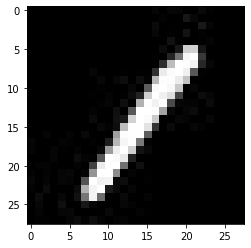

In [59]:
prediction()